# Multi-period OPF example

Multi-period OPF example with and without ESR.

No update on renewable generation and electrification load.

In [126]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import nygrid.nygrid as ng_grid
import nygrid.run_nygrid as ng_run
import nygrid.plots as ng_plots

In [127]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid', '2018Baseline')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid/2018Baseline
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


## Read grid data

### Read generator profiles

In [128]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')
verbose = True

In [129]:
# Read grid property file
grid_prop = ng_run.read_grid_prop(grid_data_dir)

# Read load and generation profiles
grid_profile = ng_run.read_grid_profile(grid_data_dir, start_date.year)

In [130]:
grid_profile['load_profile'].sum(axis=1).sort_values(ascending=False)

TimeStamp
2018-08-29 16:00:00    93203.379573
2018-08-29 15:00:00    93195.481205
2018-08-28 16:00:00    93096.897866
2018-08-28 17:00:00    92926.644148
2018-08-29 14:00:00    92834.789049
                           ...     
2018-05-13 05:00:00    35697.114653
2018-10-14 04:00:00    35637.438092
2018-05-14 03:00:00    35606.429683
2018-05-13 03:00:00    35419.794164
2018-05-13 04:00:00    35330.279322
Length: 8760, dtype: float64

In [131]:
# Set generator lower bounds to zero
grid_prop['gen_prop']['PMIN'] = np.where(grid_prop['gen_prop']['PMIN'] > 0,
                                         0, grid_prop['gen_prop']['PMIN'])
grid_profile_zero = np.where(grid_profile['genmin_profile'] > 0,
                            0, grid_profile['genmin_profile'])
grid_profile['genmin_profile'] = pd.DataFrame(grid_profile_zero, index=grid_profile['genmin_profile'].index,
                                                columns=grid_profile['genmin_profile'].columns)

In [132]:
# Increase CT and ST generation costs
ct_index = grid_prop["gen_prop"]["GEN_FUEL"].isin(
    ["Combustion Turbine", "Internal Combustion", "Jet Engine"]
).to_numpy()
st_index = grid_prop["gen_prop"]["GEN_FUEL"].isin(["Steam Turbine"]).to_numpy()

gencost1_profile_new = grid_profile['gencost1_profile'].copy()
gencost1_profile_new.loc[:, ct_index] = gencost1_profile_new.loc[:, ct_index] * 3
gencost1_profile_new.loc[:, st_index] = gencost1_profile_new.loc[:, st_index] * 3
grid_profile['gencost1_profile'] = gencost1_profile_new

## Multi-period OPF

### Without initial conditions

In [133]:
# Only run for one day
d = 0
start_datetime_0 = timestamp_list[d]
end_datetime_0 = start_datetime_0 + timedelta(hours=47)
print(f'Start time: {start_datetime_0}')
print(f'End time: {end_datetime_0}')

Start time: 2018-01-01 00:00:00
End time: 2018-01-02 23:00:00


In [134]:
# Create NYGrid object
nygrid_sim_0 = ng_grid.NYGrid(grid_prop=grid_prop,
                              start_datetime=start_datetime_0,
                              end_datetime=end_datetime_0,
                              verbose=verbose)

# Set load and generation time series data
nygrid_sim_0.set_load_sch(grid_profile['load_profile'])
nygrid_sim_0.set_gen_mw_sch(grid_profile['gen_profile'])
nygrid_sim_0.set_gen_max_sch(grid_profile['genmax_profile'])
nygrid_sim_0.set_gen_min_sch(grid_profile['genmin_profile'])
nygrid_sim_0.set_gen_ramp_sch(grid_profile['genramp30_profile'])
nygrid_sim_0.set_gen_cost_sch(grid_profile['gencost0_profile'],
                              grid_profile['gencost1_profile'])

if 'genmax_profile_vre' in grid_profile:
    nygrid_sim_0.set_vre_max_sch(grid_profile['genmax_profile_vre'])
else:
    print('No VRE generation data.')

# Relax branch flow limits
nygrid_sim_0.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_0.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 5_000,
    # 'PenaltyForInterfaceMWViolation': 5_000
}

nygrid_sim_0.set_options(options)

# Solve DC OPF
nygrid_sim_0.solve_dc_opf()

# Get results
results_0 = nygrid_sim_0.get_results_dc_opf()

No VRE generation data.
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpajtupfd9.pyomo.lp
Reading time = 0.26 seconds
x1: 83226 rows, 69553 columns, 410662 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 83226 rows, 69553 columns and 410662 nonzeros
Model fingerprint: 0xf651b784
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 74628 rows and 53247 columns
Presolve time: 0.12s
Presolved: 8598 rows, 16306 columns, 60907 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.087e+04
 Fac

In [135]:
print("s_ramp_up", results_0['s_ramp_up'].sum())
print("s_ramp_down", results_0['s_ramp_down'].sum())
print("s_over_gen", results_0['s_over_gen'].sum())
print("s_load_shed", results_0['s_load_shed'].sum())
print("s_if_max", results_0['s_if_max'].sum())
print("s_if_min", results_0['s_if_min'].sum())
print("s_br_max", results_0['s_br_max'].sum())
print("s_br_min", results_0['s_br_min'].sum())
print("s_esr_pcrg", results_0['s_esr_pcrg'].sum())
print("s_esr_pdis", results_0['s_esr_pdis'].sum())
print("s_esr_soc_min", results_0['s_esr_soc_min'].sum())
print("s_esr_soc_max", results_0['s_esr_soc_max'].sum())
print("s_esr_soc_overt", results_0['s_esr_soc_overt'].sum())
print("s_esr_soc_undert", results_0['s_esr_soc_undert'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 140755.10637219547
s_if_max 1201390.4261558815
s_if_min 120379.61851857549
s_br_max 0.0
s_br_min 0.0
s_esr_pcrg 0.0
s_esr_pdis 0.0
s_esr_soc_min 0.0
s_esr_soc_max 0.0
s_esr_soc_overt 0.0
s_esr_soc_undert 7581.0


### With initial conditions

In [136]:
# Only run for one day
d = d+1
start_datetime_1 = timestamp_list[d]
end_datetime_1 = start_datetime_1 + timedelta(hours=47)
print(f'Start time: {start_datetime_1}')
print(f'End time: {end_datetime_1}')

Start time: 2018-01-02 00:00:00
End time: 2018-01-03 23:00:00


In [137]:
# Create NYGrid object
nygrid_sim_1 = ng_grid.NYGrid(grid_prop=grid_prop,
                              start_datetime=start_datetime_1,
                              end_datetime=end_datetime_1,
                              verbose=verbose)

# Set load and generation time series data
nygrid_sim_1.set_load_sch(grid_profile['load_profile'])
nygrid_sim_1.set_gen_mw_sch(grid_profile['gen_profile'])
nygrid_sim_1.set_gen_max_sch(grid_profile['genmax_profile'])
nygrid_sim_1.set_gen_min_sch(grid_profile['genmin_profile'])
nygrid_sim_1.set_gen_ramp_sch(grid_profile['genramp30_profile'])
nygrid_sim_1.set_gen_cost_sch(grid_profile['gencost0_profile'],
                              grid_profile['gencost1_profile'])

if 'genmax_profile_vre' in grid_profile:
    nygrid_sim_1.set_vre_max_sch(grid_profile['genmax_profile_vre'])

# Relax branch flow limits
nygrid_sim_1.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0['PG'].loc[start_datetime_1].to_numpy().squeeze()
nygrid_sim_1.set_gen_init_data(gen_init=last_gen)

# Set ESR initial condition for the next iteration
last_soc = results_0['esrSOC'].loc[start_datetime_1].to_numpy().squeeze()
nygrid_sim_1.set_esr_init_data(esr_init=last_soc)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1.set_options(options)

# Solve DC OPF
nygrid_sim_1.solve_dc_opf()

# Get results
results_1 = nygrid_sim_1.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpx8aos5rp.pyomo.lp
Reading time = 0.26 seconds
x1: 83864 rows, 69553 columns, 411938 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 83864 rows, 69553 columns and 411938 nonzeros
Model fingerprint: 0xb58e024d
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 75156 rows and 53034 columns
Presolve time: 0.12s
Presolved: 8708 rows, 16519 columns, 62157 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.226e+04
 Factor NZ  : 2.530e+05 (rou

In [138]:
print("s_ramp_up", results_1['s_ramp_up'].sum())
print("s_ramp_down", results_1['s_ramp_down'].sum())
print("s_over_gen", results_1['s_over_gen'].sum())
print("s_load_shed", results_1['s_load_shed'].sum())
print("s_if_max", results_1['s_if_max'].sum())
print("s_if_min", results_1['s_if_min'].sum())
print("s_br_max", results_1['s_br_max'].sum())
print("s_br_min", results_1['s_br_min'].sum())
print("s_esr_pcrg", results_1['s_esr_pcrg'].sum())
print("s_esr_pdis", results_1['s_esr_pdis'].sum())
print("s_esr_soc_min", results_1['s_esr_soc_min'].sum())
print("s_esr_soc_max", results_1['s_esr_soc_max'].sum())
print("s_esr_soc_overt", results_1['s_esr_soc_overt'].sum())
print("s_esr_soc_undert", results_1['s_esr_soc_undert'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 148801.29862504924
s_if_max 822531.5325695124
s_if_min 104961.11693066709
s_br_max 0.0
s_br_min 0.0
s_esr_pcrg 0.0
s_esr_pdis 0.0
s_esr_soc_min 0.0
s_esr_soc_max 0.0
s_esr_soc_overt 0.0
s_esr_soc_undert 7581.0


## Process the results

### Costs

In [139]:
print(f'Total cost: {results_0["total_cost"].sum():.2f}')
print(f'Total penalty: {results_0["total_penalty"].sum():.2f}')
print(f'Total cost and penalty: {results_0["total_cost_penalty"].sum():.2f}')

print(f'Gen cost: {results_0["gen_cost"].sum():.2f}')
print(f'ESR cost: {results_0["esr_cost"].sum():.2f}')

print(f'Over generation penalty: {results_0["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_0["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_0["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_0["ramp_down_penalty"].sum():.2f}')
print(f'Interface max penalty: {results_0["if_max_penalty"].sum():.2f}')
print(f'Interface min penalty: {results_0["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_0["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_0["br_min_penalty"].sum():.2f}')

print(f'ESR Charging power penalty: {results_0["esr_pcrg_penalty"].sum():.2f}')
print(f'ESR Discharging power penalty: {results_0["esr_pdis_penalty"].sum():.2f}')
print(f'ESR SOC max penalty: {results_0["esr_soc_max_penalty"].sum():.2f}')
print(f'ESR SOC min penalty: {results_0["esr_soc_min_penalty"].sum():.2f}')
print(f'ESR SOC over target penalty: {results_0["esr_soc_overt_penalty"].sum():.2f}')
print(f'ESR SOC under target penalty: {results_0["esr_soc_undert_penalty"].sum():.2f}')


Total cost: 186217492.45
Total penalty: 41406626.72
Total cost and penalty: 227624119.17
Gen cost: 186217469.07
ESR cost: 23.38
Over generation penalty: 0.00
Load shed penalty: 28151021.27
Ramp up penalty: 0.00
Ramp down penalty: 0.00
Interface max penalty: 12013904.26
Interface min penalty: 1203796.19
Branch max penalty: 0.00
Branch min penalty: 0.00
ESR Charging power penalty: 0.00
ESR Discharging power penalty: 0.00
ESR SOC max penalty: 0.00
ESR SOC min penalty: 0.00
ESR SOC over target penalty: 0.00
ESR SOC under target penalty: 37905.00


In [140]:
print(f'Total cost: {results_1["total_cost"].sum():.2f}')
print(f'Total penalty: {results_1["total_penalty"].sum():.2f}')
print(f'Total cost and penalty: {results_1["total_cost_penalty"].sum():.2f}')

print(f'Gen cost: {results_1["gen_cost"].sum():.2f}')
print(f'ESR cost: {results_1["esr_cost"].sum():.2f}')

print(f'Over generation penalty: {results_1["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_1["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_1["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_1["ramp_down_penalty"].sum():.2f}')
print(f'Interface max penalty: {results_1["if_max_penalty"].sum():.2f}')
print(f'Interface min penalty: {results_1["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_1["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_1["br_min_penalty"].sum():.2f}')

print(f'ESR Charging power penalty: {results_1["esr_pcrg_penalty"].sum():.2f}')
print(f'ESR Discharging power penalty: {results_1["esr_pdis_penalty"].sum():.2f}')
print(f'ESR SOC max penalty: {results_1["esr_soc_max_penalty"].sum():.2f}')
print(f'ESR SOC min penalty: {results_1["esr_soc_min_penalty"].sum():.2f}')
print(f'ESR SOC over target penalty: {results_1["esr_soc_overt_penalty"].sum():.2f}')
print(f'ESR SOC under target penalty: {results_1["esr_soc_undert_penalty"].sum():.2f}')


Total cost: 229035890.08
Total penalty: 39073091.22
Total cost and penalty: 268108981.30
Gen cost: 229035879.29
ESR cost: 10.80
Over generation penalty: 0.00
Load shed penalty: 29760259.73
Ramp up penalty: 0.00
Ramp down penalty: 0.00
Interface max penalty: 8225315.33
Interface min penalty: 1049611.17
Branch max penalty: 0.00
Branch min penalty: 0.00
ESR Charging power penalty: 0.00
ESR Discharging power penalty: 0.00
ESR SOC max penalty: 0.00
ESR SOC min penalty: 0.00
ESR SOC over target penalty: 0.00
ESR SOC under target penalty: 37905.00


### LMP

In [141]:
# Create a dict where key is busIdx and value is zoneID
bus_zone_alloc = nygrid_sim_0.grid_prop['bus_prop'].set_index(
    'BUS_I').to_dict()['BUS_ZONE']
bus_names = list(bus_zone_alloc.keys())
bus_names_str = [f'Bus{i}' for i in bus_names]

In [142]:
lmp_0 = results_0['LMP']
lmp_0.columns = bus_names

# Aggregate LMPs by zone
lmp_0_zone = lmp_0.T.groupby(bus_zone_alloc).mean().T

lmp_1 = results_1['LMP']
lmp_1.columns = bus_names

# Aggregate LMPs by zone
lmp_1_zone = lmp_1.T.groupby(bus_zone_alloc).mean().T

Text(0.5, 0.98, 'LMP')

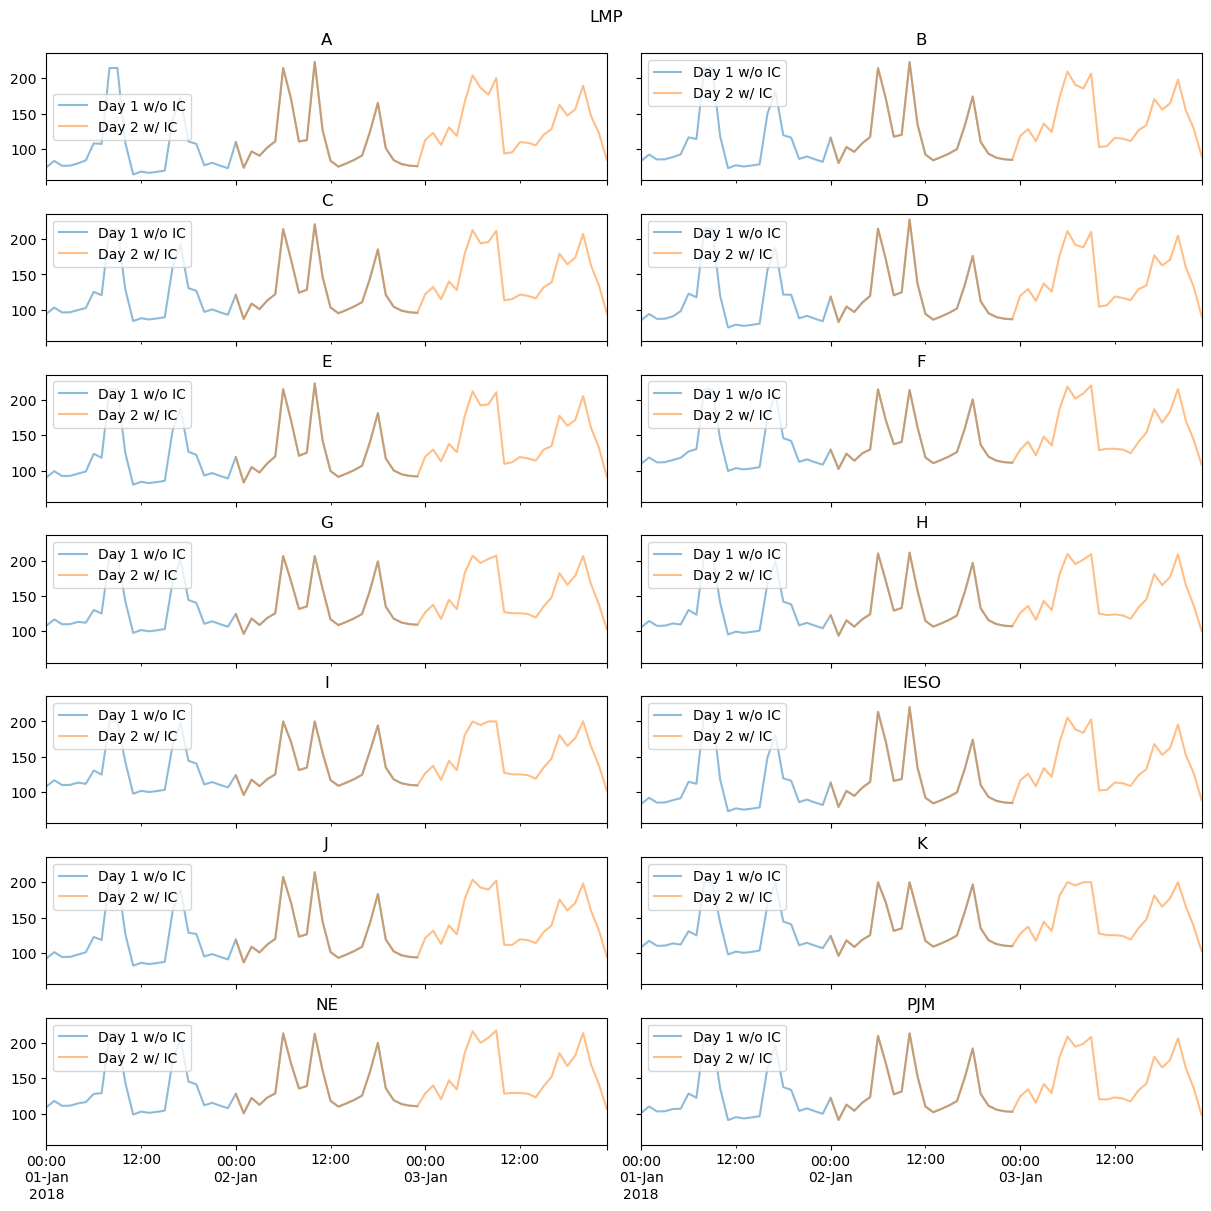

In [143]:
fig, axs = plt.subplots(7, 2, figsize=(12, 12), 
                        sharex='all', sharey='all',
                        layout='constrained')
# Plot LMPs w/o ESR
for i, ax in enumerate(axs.flat):
    lmp_0_zone.iloc[:, i].plot(ax=ax, label='Day 1 w/o IC', alpha=0.5)
    lmp_1_zone.iloc[:, i].plot(ax=ax, label='Day 2 w/ IC', alpha=0.5)
    ax.set_title(lmp_1_zone.columns[i])
    ax.legend()
fig.suptitle('LMP')

### ESR

In [144]:
ii = 6
crg_max = grid_prop['esr_prop']['ESR_CRG_MAX'].iloc[ii]
dis_max = grid_prop['esr_prop']['ESR_DIS_MAX'].iloc[ii]
crg_eff = grid_prop['esr_prop']['ESR_CRG_EFF'].iloc[ii]
dis_eff = grid_prop['esr_prop']['ESR_DIS_EFF'].iloc[ii]
soc_init = grid_prop['esr_prop']['ESR_SOC_INI'].iloc[ii]
soc_max = grid_prop['esr_prop']['ESR_SOC_MAX'].iloc[ii]

print(f'crg_max: {crg_max}, dis_max: {dis_max}, crg_eff: {crg_eff}, dis_eff: {dis_eff}, soc_init: {soc_init}, soc_max: {soc_max}')


crg_max: 2.0, dis_max: 2.0, crg_eff: 0.85, dis_eff: 0.85, soc_init: 4, soc_max: 8


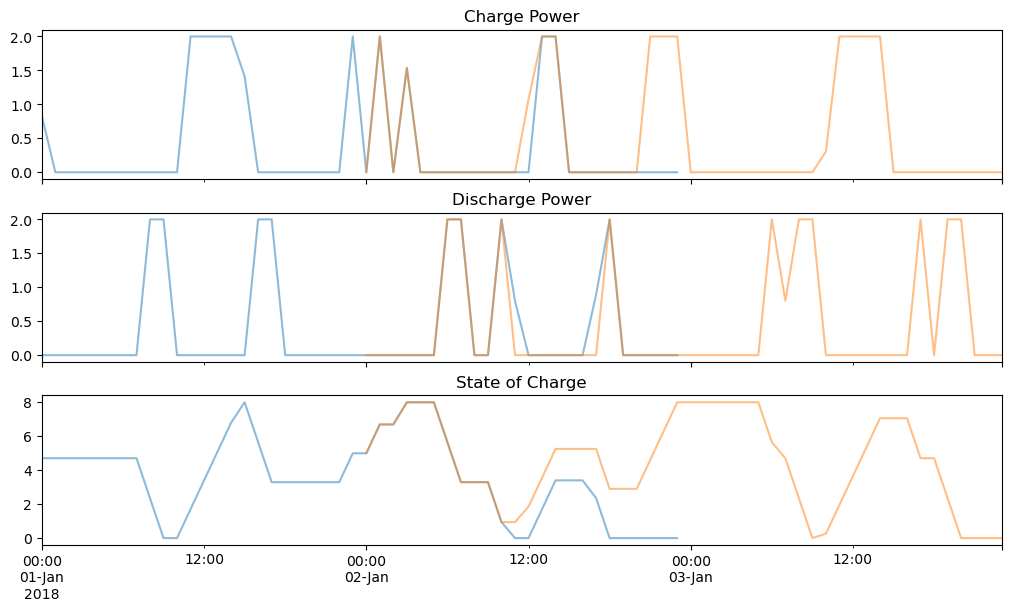

In [145]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6),
                       sharex=True, layout='constrained')

results_0['esrPCrg'].iloc[:, ii].plot(ax=axs[0], label='Day 1 w/o IC', alpha=0.5)
results_0['esrPDis'].iloc[:, ii].plot(ax=axs[1], label='Day 1 w/o IC', alpha=0.5)
results_0['esrSOC'].iloc[:, ii].plot(ax=axs[2], label='Day 1 w/o IC', alpha=0.5)

results_1['esrPCrg'].iloc[:, ii].plot(ax=axs[0], label='Day 2 w/ IC', alpha=0.5)
results_1['esrPDis'].iloc[:, ii].plot(ax=axs[1], label='Day 2 w/ IC', alpha=0.5)
results_1['esrSOC'].iloc[:, ii].plot(ax=axs[2], label='Day 2 w/ IC', alpha=0.5)

titles = ['Charge Power', 'Discharge Power', 'State of Charge']
for i, ax in enumerate(axs):
    ax.set_title(titles[i])

### Thermal generation

In [146]:
# Read thermal generator info table
filename = os.path.join(grid_data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i]
              for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [147]:
# Format results
thermal_pg_0 = (results_0['PG'].iloc[:, :num_thermal]
                .rename(columns=gen_rename))

thermal_pg_1 = (results_1['PG'].iloc[:, :num_thermal]
                .rename(columns=gen_rename))

In [148]:
gen_info[gen_info['PTID'] == 23512]

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
7,Arthur Kill ST 2,23512,J,Steam Turbine,Natural Gas,40.5915,-74.2027,349.0,96.0,34.9,...,349.0,8.666516,252.390433,0.995837,0.000772,8.373115,274.28691,0.99586,1,10m


In [149]:
def plot_gen(thermal_pg: pd.Series,
             gen_hist: pd.Series,
             gen_max: pd.Series,
             gen_min: pd.Series,
             ax: plt.Axes,
             title) -> plt.Axes:

    ax.plot(thermal_pg.index, thermal_pg,
            marker='^', label='OPF',
            linewidth=5, alpha=0.7, markersize=10)
    ax.plot(thermal_pg.index, gen_hist,
            marker='o', label='OPF MATLAB',
            linewidth=5, alpha=0.7, markersize=10)
    ax.plot(thermal_pg.index, gen_max,
            linestyle='--', label='max',
            linewidth=5, alpha=0.7, markersize=10)
    ax.plot(thermal_pg.index, gen_min,
            linestyle='--', label='min',
            linewidth=5, alpha=0.7, markersize=10)
    ax.legend()
    if title:
        ax.set_title(title)

    return ax

NYISOName        Arthur Kill ST 3
PTID                        23513
Zone                            J
UnitType            Steam Turbine
FuelType              Natural Gas
Latitude                  40.5915
Longitude                -74.2027
maxPower                    539.0
minPower                      1.0
maxRampAgc                   53.9
maxRamp10                   539.0
maxRamp30                   539.0
maxRamp60                   539.0
HeatRateLM_1              8.88948
HeatRateLM_0           340.374965
HeatRateLM_R2            0.986235
HeatRateQM_2            -0.003565
HeatRateQM_1            10.324775
HeatRateQM_0           231.015136
HeatRateQM_R2             0.99146
useQM                           1
start-time                    10m
Name: 8, dtype: object

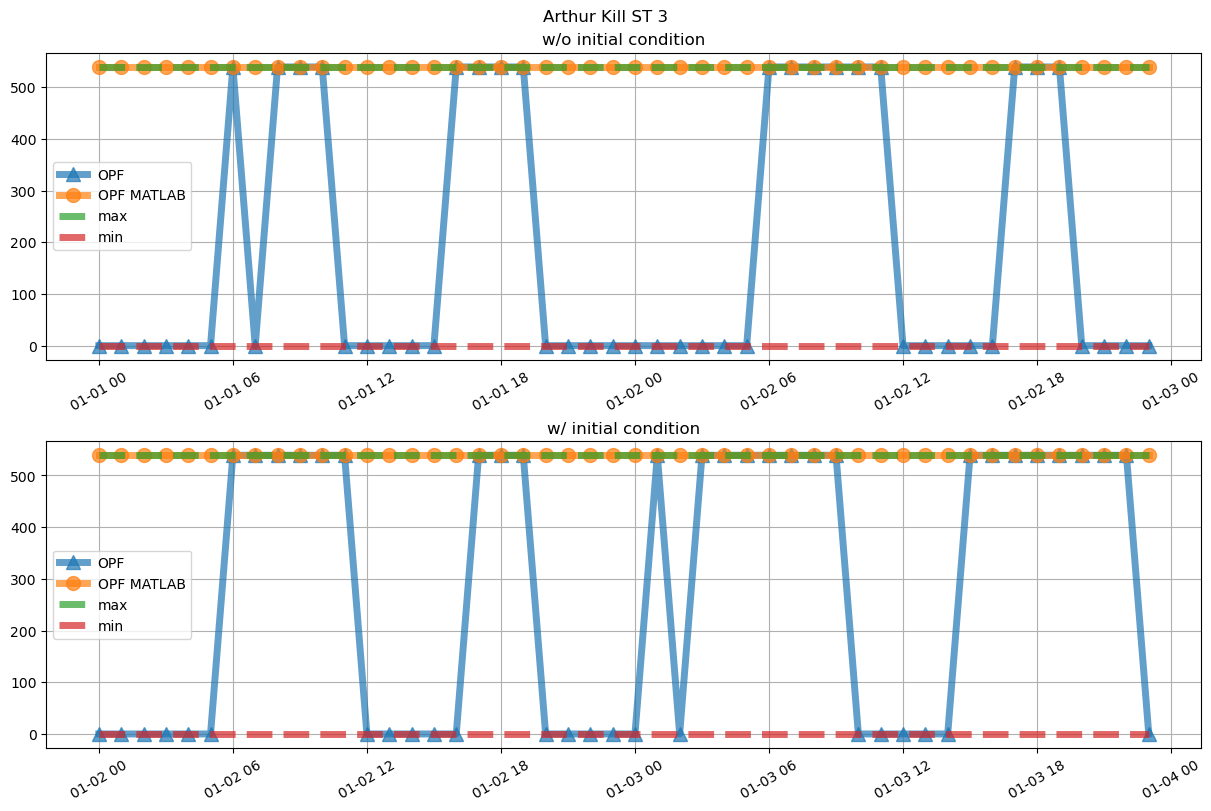

In [150]:
ii = 8
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 1, figsize=(12, 8), layout='constrained')

axs[0] = plot_gen(thermal_pg_0.iloc[:, ii],
                           grid_profile['gen_profile'][start_datetime_0:end_datetime_0].iloc[:, ii],
                           grid_profile['genmax_profile'][start_datetime_0:end_datetime_0].iloc[:, ii],
                           grid_profile['genmin_profile'][start_datetime_0:end_datetime_0].iloc[:, ii],
                           ax=axs[0], title="w/o initial condition")

axs[1] = plot_gen(thermal_pg_1.iloc[:, ii],
                           grid_profile['gen_profile'][start_datetime_1:end_datetime_1].iloc[:, ii],
                           grid_profile['genmax_profile'][start_datetime_1:end_datetime_1].iloc[:, ii],
                           grid_profile['genmin_profile'][start_datetime_1:end_datetime_1].iloc[:, ii],
                           ax=axs[1], title="w/ initial condition")

for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)
    ax.grid()

fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()